## Feature Engineering

### Dimentionality Reduction

##### In this notebook we try to find unnecessary features and remove them from data, so the model can train easier and generalize better .

##### So far we have cleaned our data and searched for best possible hyper-parameters. Results are as below:

* Result don't change if we apply standard scaler on all features (OneHotEncoded categories and continuous) or only on continous features
* **RandomForestRegressor** works better than XGBRegressor with this dataset
* Best hyper-parameters: `n_estimators`=150, `max_depth`=None, `min_samples_leaf`=2, `max_features`=0.5
* Model produces better result when DV is not transformed. So we keep the original target values.
* Best results so far: `MAE`: 1.20551, `R^2`: 0.81978
<br><br><br>


### Loading Data and environment setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# loading libraries
import numpy as np
import pandas as pd
from scipy import stats
from scipy.cluster import hierarchy as hc
import matplotlib.pyplot as plt
import os
import time

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA, SparsePCA

In [3]:
# setting paths
data_dir = os.path.abspath('./_data')
train_data_fp = os.path.join(data_dir, 'train_clean.csv')
test_data_fp = os.path.join(data_dir, 'test_clean.csv')
data_fp = os.path.join(data_dir, 'data_clean.csv')
os.listdir(data_dir)

['data.csv',
 'train_clean_all_scaled.csv',
 'test_clean_all_scaled.csv',
 'data_clean.csv',
 'to_keep_columns_stage1.npy',
 'to_keep_columns_stage2.npy',
 'data_no_missing.csv',
 'data_clean_all_scaled.csv',
 'train_clean.csv',
 'test_clean.csv',
 'test.csv']

In [4]:
# load the training set and shuffle it
train_set = pd.read_csv(train_data_fp)
train_set = train_set.sample(frac=1)
train_set.head(1)

,ch_type,length,first_or_rerun,episodes_in_season,is_movie,overlaped_with_game,temperature,Is_month_end,Is_month_start,Is_quarter_end,...,Month_12,Dayofweek_0,Dayofweek_1,Dayofweek_2,Dayofweek_3,Dayofweek_4,Dayofweek_5,Dayofweek_6,market_share,market_share_transformed
129620,1,0.152892,0,1,0,0,-1.329417,0,0,0,...,0,0,0,0,0,0,0,1,3.5,0.014001


In [5]:
# cut the dependant variable(s) form training set
# target = train_set.loc[:, 'market_share_transformed']
target_src = train_set.loc[:, 'market_share']
# targets_joint = train_set.loc[:, ['market_share_transformed', 'market_share']]

train_set.drop(columns=['market_share', 'market_share_transformed'], inplace=True)

In [6]:
# constant variables for later use
cv = 5    # number of folds for cross-validation
rs = 1    # random-state number
sample_size_large = 300000
sample_size_small = 35000

### Defining few helper functions

In [7]:
def get_rf_model(n_estimators=150, max_depth=None, min_samples_leaf=2, max_features=0.5, random_state=rs):
    rf = RandomForestRegressor(n_estimators=n_estimators,
                               max_depth=max_depth,
                               min_samples_leaf=min_samples_leaf,
                               max_features=max_features,
                               oob_score=True,
                               n_jobs=-1,
                               random_state=random_state)
    return rf

In [8]:
def evaluate(actual, prediction):
    return {'MAE': round(mean_absolute_error(actual, prediction), 5),
            'MSE': round(mean_squared_error(actual, prediction), 5),
            'R^2': round(r2_score(actual, prediction), 5)}

In [9]:
def get_oob_score(X_train, y_train):
    rf = RandomForestRegressor(n_estimators=30, min_samples_leaf=2, max_features=0.5, oob_score=True, n_jobs=-1, random_state=rs)
    rf.fit(X_train, y_train)
    score = rf.oob_score_
    del rf
    return round(score, 5)

In [10]:
get_oob_score(train_set.iloc[:sample_size_small], target_src.iloc[:sample_size_small])

0.74617

In [11]:
def get_sample_df(X_train, y_train, n_samples=20000):
    df = pd.concat(objs=[X_train, y_train], axis=1)
    x = df.sample(n=n_samples, axis=0)
    del df
    return x.iloc[:, :-1], x.iloc[:, -1]

In [12]:
def plot_feature_importance(fi, labels, n_features=None, figsize=(14, 8)):
    nf = n_features if n_features is not None else len(fi)
    
    fi = sorted(zip(fi, labels), reverse=True)[:nf]
    d = d = {k: v for v, k in fi}
    plt.figure(figsize=figsize)
    plt.bar(range(len(d)), list(d.values()), align='center')
    plt.xticks(range(len(d)), list(d.keys()), rotation='vertical')
    plt.show()
    del d

In [13]:
def full_eval(rf, X_train, y_train, X_test, y_test):
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    res = evaluate(y_test, preds)
    res['oob_score'] = round(rf.oob_score_, 5)
    return res
    

### Create sample train and test sets for later analysis

In [14]:
X_train, y_train = get_sample_df(train_set, target_src, n_samples=sample_size_large)
X_train.shape, y_train.shape

((300000, 91), (300000,))

In [15]:
X_test, y_test = get_sample_df(train_set, target_src, n_samples=sample_size_small)
X_test.shape, y_test.shape

((35000, 91), (35000,))

## 1. Get the most important features

In [17]:
%%time

rf = get_rf_model()
rf.fit(X_train, y_train)

CPU times: user 19min 24s, sys: 2.72 s, total: 19min 27s
Wall time: 2min 38s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=-1, oob_score=True,
                      random_state=1, verbose=0, warm_start=False)

In [18]:
preds = rf.predict(X_test)

print('oob_score: %.5f' % rf.oob_score_)
evaluate(y_test, preds)

oob_score: 0.80496


{'MAE': 1.01678, 'MSE': 3.2929, 'R^2': 0.86063}

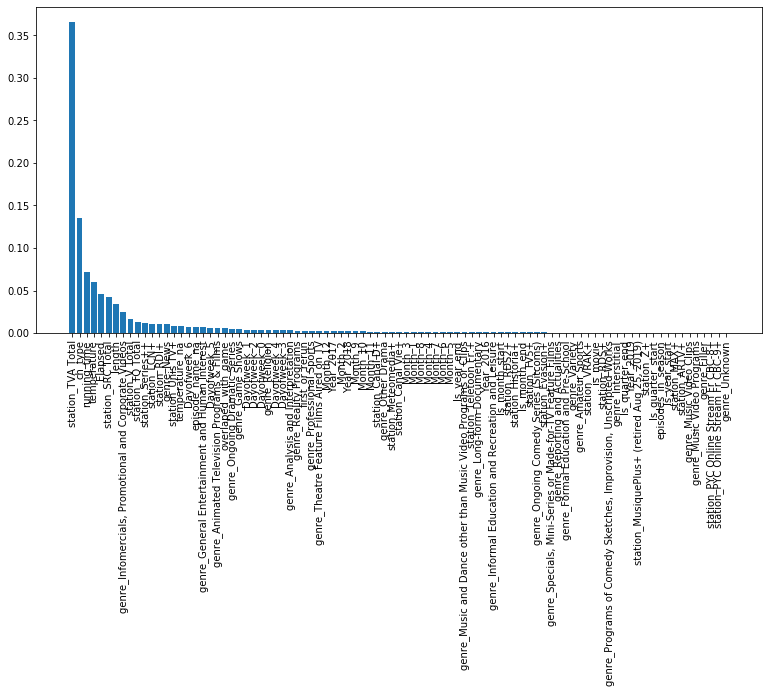

In [19]:
plot_feature_importance(rf.feature_importances_, X_train.columns, figsize=(13, 6))

In [20]:
fi = sorted(zip(rf.feature_importances_, X_train.columns), reverse=True)
to_keep = np.asarray([k for v, k in fi if v > 0.0013])
len(to_keep)

50

In [21]:
to_keep = to_keep[:50]

In [22]:
%%time

rf2 = get_rf_model()
rf2.fit(X_train[to_keep], y_train)

CPU times: user 12min 2s, sys: 1.68 s, total: 12min 4s
Wall time: 1min 38s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=-1, oob_score=True,
                      random_state=1, verbose=0, warm_start=False)

In [23]:
preds_reduced = rf2.predict(X_test[to_keep])
print('oob_score: %.5f' % rf2.oob_score_)
evaluate(y_test, preds_reduced)

oob_score: 0.79441


{'MAE': 1.07472, 'MSE': 3.49142, 'R^2': 0.85223}

In [24]:
# save extracted columns name to diske for later use
np.save(data_dir + '/to_keep_columns_stage1.npy', to_keep)

#### Section Summary:
**Since our model's performance only dropped slightly, keeping 50 most important features is good enough to continue.**

### 2. Hierarical Clustering Analysis (Pairwise Correlations)

In [25]:
to_keep = np.load(data_dir + '/to_keep_columns_stage1.npy')
to_keep.shape

(50,)

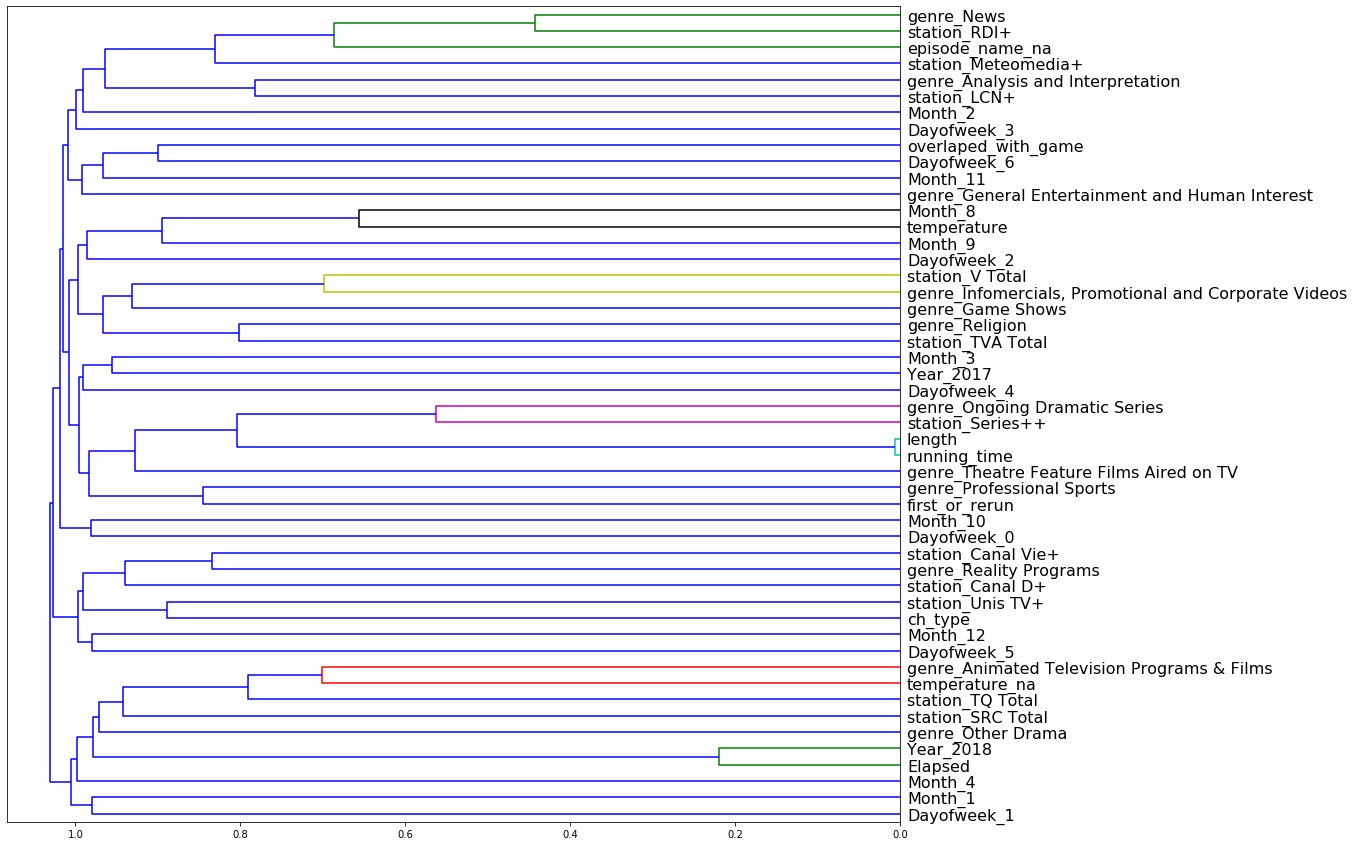

In [27]:
corr = np.round(stats.spearmanr(X_train[to_keep]).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
Z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16, 15))
dendrogram = hc.dendrogram(Z, labels=X_train[to_keep].columns, orientation='left', leaf_font_size=16)
plt.show()

In [28]:
%%time
# evaluating model's performance with extracted columns -- (for reference only)
full_eval(get_rf_model(), X_train[to_keep], y_train, X_test[to_keep], y_test)

CPU times: user 12min 4s, sys: 1.7 s, total: 12min 5s
Wall time: 1min 42s


{'MAE': 1.07472, 'MSE': 3.49142, 'R^2': 0.85223, 'oob_score': 0.79441}

In [29]:
# removing 'length' feature
to_keep_new = to_keep[to_keep!= 'length']

In [30]:
%%time
# re-evaluating model's performance after dropping 'length' feature
full_eval(get_rf_model(), X_train[to_keep_new], y_train, X_test[to_keep_new], y_test)

CPU times: user 11min 23s, sys: 1.76 s, total: 11min 25s
Wall time: 1min 34s


{'MAE': 1.07997, 'MSE': 3.52181, 'R^2': 0.85094, 'oob_score': 0.79419}

In [31]:
np.save(data_dir + '/to_keep_columns_stage2.npy', to_keep_new)

#### Section Summary:
**Based on above dendrogram plot, the only two related features are _running_time_ and _length_ and we tested that removing _length_ feature didn't drop our model's performance.**

### 3. Sparse Features Grouping --- not completed

In [16]:
to_keep = np.load(data_dir + '/to_keep_columns_stage2.npy')
to_keep.shape

(49,)

In [17]:
X_train = X_train[to_keep]
X_test = X_test[to_keep]

In [18]:
%%time

rf = get_rf_model()
rf.fit(X_train, y_train)
preds = rf.predict(X_test)
print('oob_score: %.5f' % rf.oob_score_)
evaluate(y_test, preds)

oob_score: 0.79282
CPU times: user 11min 22s, sys: 1.96 s, total: 11min 24s
Wall time: 1min 35s


{'MAE': 1.0711, 'MSE': 3.40046, 'R^2': 0.8534}

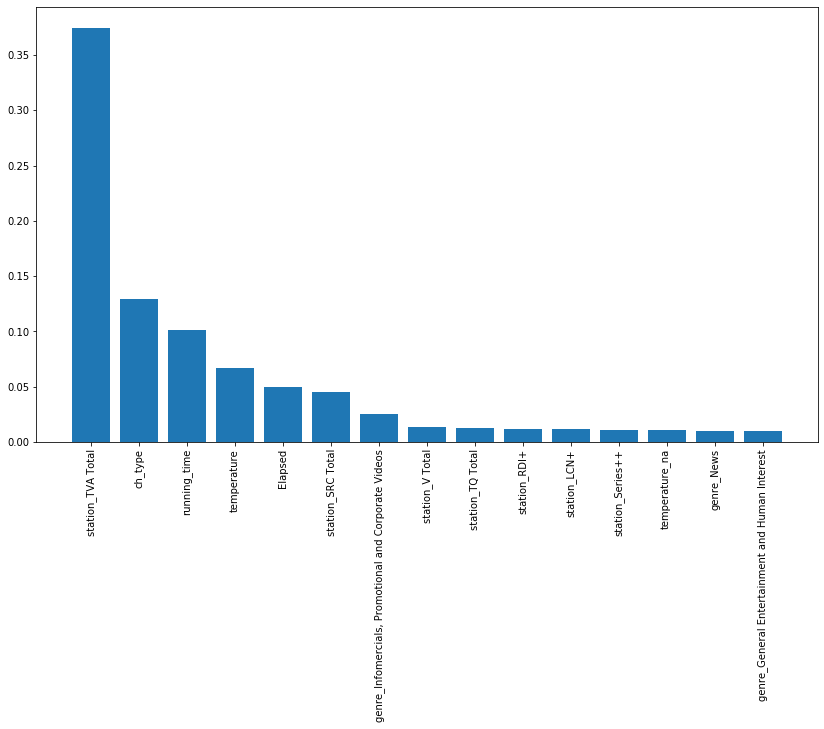

In [19]:
plot_feature_importance(rf.feature_importances_, X_train.columns, n_features=15)

**It looks like lots of features in our _'to_keep'_ list are _'station', 'genre', 'Dayofweek'_ and _'Month'_ related**

In [20]:
to_keep

array(['station_TVA Total', 'ch_type', 'running_time', 'temperature',
       'Elapsed', 'station_SRC Total',
       'genre_Infomercials, Promotional and Corporate Videos',
       'station_V Total', 'station_TQ Total', 'station_Series++',
       'station_LCN+', 'station_RDI+', 'genre_News', 'station_Unis TV+',
       'temperature_na', 'Dayofweek_6', 'episode_name_na',
       'genre_General Entertainment and Human Interest', 'Dayofweek_5',
       'genre_Animated Television Programs & Films',
       'overlaped_with_game', 'genre_Ongoing Dramatic Series',
       'genre_Game Shows', 'Dayofweek_1', 'Dayofweek_2', 'Dayofweek_0',
       'genre_Religion', 'Dayofweek_4', 'Dayofweek_3',
       'genre_Analysis and Interpretation', 'genre_Reality Programs',
       'first_or_rerun', 'genre_Professional Sports',
       'genre_Theatre Feature Films Aired on TV', 'Month_12', 'Year_2017',
       'Month_2', 'Year_2018', 'Month_9', 'Month_10', 'Month_11',
       'station_Canal D+', 'genre_Other Drama', 's

In [21]:
col_stations = np.asarray([col for col in to_keep if col.startswith('station')])
col_genres = np.asarray([col for col in to_keep if col.startswith('genre')])
col_weekday = np.asarray([col for col in to_keep if col.startswith('Dayofweek')])
col_months = np.asarray([col for col in to_keep if col.startswith('Month')])


print(f'Stations: {len(col_stations)}')
print(f'Genres: {len(col_genres)}')
print(f'Days of Week: {len(col_weekday)}')
print(f'Months: {len(col_months)}')

Stations: 11
Genres: 12
Days of Week: 7
Months: 9


### - _`Dayofweek__*`_ feature

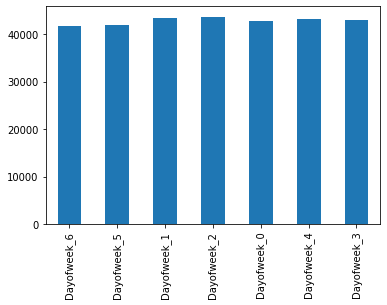

In [24]:
X_train[col_weekday].sum().plot(kind='bar')

In [25]:
X_train[col_weekday].var()

Dayofweek_6    0.119602
Dayofweek_5    0.120576
Dayofweek_1    0.123904
Dayofweek_2    0.124432
Dayofweek_0    0.122392
Dayofweek_4    0.123184
Dayofweek_3    0.123020
dtype: float64

**Amount of variation in different days of the week are roughly equal, so we keep the first 3 more important days and combine the rest.**

In [26]:
col_weekday_keep = col_weekday[:3]
col_weekday_comb = col_weekday[3:]
col_weekday_keep, col_weekday_comb

(array(['Dayofweek_6', 'Dayofweek_5', 'Dayofweek_1'], dtype='<U11'),
 array(['Dayofweek_2', 'Dayofweek_0', 'Dayofweek_4', 'Dayofweek_3'],
       dtype='<U11'))

In [34]:
X_train_weekday = X_train.copy()
X_test_weekday = X_test.copy()

In [35]:
def combine_weekday(row, weekdays):
    if row[weekdays].sum() >= 1:
        return 1
    return 0

In [36]:
X_train_weekday['Dayofweek_other'] = X_train_weekday.apply(lambda x: combine_weekday(x, col_weekday_comb), axis=1)
X_test_weekday['Dayofweek_other'] = X_test_weekday.apply(lambda x: combine_weekday(x, col_weekday_comb), axis=1)

In [37]:
X_train_weekday.drop(columns=col_weekday_comb, inplace=True)
X_test_weekday.drop(columns=col_weekday_comb, inplace=True)

X_train_weekday.shape, X_test_weekday.shape

((300000, 46), (35000, 46))

In [38]:
%%time

rf = get_rf_model()
rf.fit(X_train_weekday, y_train)
preds = rf.predict(X_test_weekday)
print('oob_score: %.5f' % rf.oob_score_)
evaluate(y_test, preds)

oob_score: 0.78834
CPU times: user 10min 51s, sys: 838 ms, total: 10min 52s
Wall time: 1min 29s


{'MAE': 1.08271, 'MSE': 3.47115, 'R^2': 0.85035}

In [ ]:
# oob_score: 0.79419
# {'MAE': 1.07997, 'MSE': 3.52181, 'R^2': 0.85094}

### - _`genre__*`_ feature

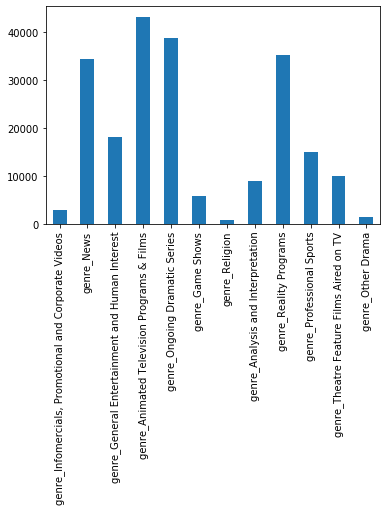

In [39]:
X_train[col_genres].sum().plot(kind='bar')

In [40]:
col_genres

array(['genre_Infomercials, Promotional and Corporate Videos',
       'genre_News', 'genre_General Entertainment and Human Interest',
       'genre_Animated Television Programs & Films',
       'genre_Ongoing Dramatic Series', 'genre_Game Shows',
       'genre_Religion', 'genre_Analysis and Interpretation',
       'genre_Reality Programs', 'genre_Professional Sports',
       'genre_Theatre Feature Films Aired on TV', 'genre_Other Drama'],
      dtype='<U52')

In [41]:
genres_comb = ['genre_Infomercials, Promotional and Corporate Videos', 'genre_Religion', 'genre_Other Drama']

In [42]:
def combine_genres(row, genres):
    if row[genres].sum() >= 1:
        return 1
    return 0

In [43]:
X_train_genre = X_train_weekday.copy()
X_test_genre = X_test_weekday.copy()

X_train_genre.shape, X_test_genre.shape

((300000, 46), (35000, 46))

In [44]:
X_train_genre['genre_comb'] = X_train_genre.apply(lambda x: combine_genres(x, genres_comb), axis=1)
X_test_genre['genre_comb'] = X_test_genre.apply(lambda x: combine_genres(x, genres_comb), axis=1)

X_train_genre.drop(columns=genres_comb, inplace=True)
X_test_genre.drop(columns=genres_comb, inplace=True)

In [51]:
# First eval performance
# {'MAE': 1.01678, 'MSE': 3.2929, 'R^2': 0.86063, oob_score: 0.80496}

# Before combining genre performance
# {'MAE': 1.08271, 'MSE': 3.47115, 'R^2': 0.85035, oob_score: 0.78834}

# After combining 3 sparse genres
# {'MAE': 1.08236, 'MSE': 3.48475, 'R^2': 0.84976, 'oob_score': 0.78761}

In [46]:
%%time

rf = get_rf_model()
full_eval(rf, X_train_genre, y_train, X_test_genre, y_test)

CPU times: user 10min 29s, sys: 1.18 s, total: 10min 30s
Wall time: 1min 26s


{'MAE': 1.08236, 'MSE': 3.48475, 'R^2': 0.84976, 'oob_score': 0.78761}

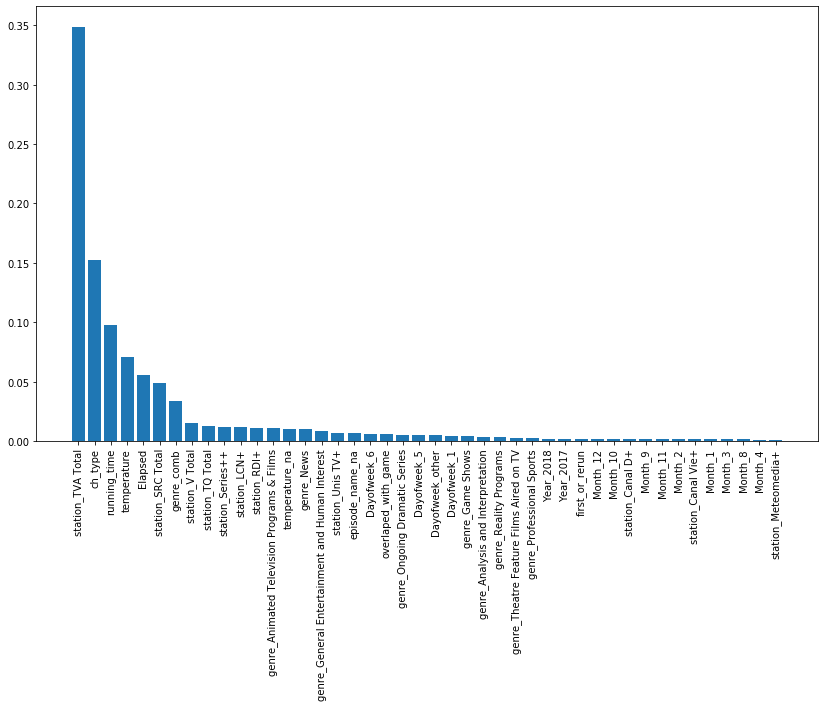

In [52]:
plot_feature_importance(rf.feature_importances_, X_train_genre.columns)

### Dropping the most important feature !

In [53]:
X_train_genre.columns[:1]

Index(['station_TVA Total'], dtype='object')

In [54]:
%%time

rf = get_rf_model()
full_eval(rf, X_train_genre.drop(columns=['station_TVA Total']), y_train, X_test_genre.drop(columns=['station_TVA Total']), y_test)

CPU times: user 9min 57s, sys: 650 ms, total: 9min 58s
Wall time: 1min 22s


{'MAE': 1.08274, 'MSE': 3.47526, 'R^2': 0.85017, 'oob_score': 0.78788}

In [ ]:
# {'MAE': 1.08236, 'MSE': 3.48475, 'R^2': 0.84976, 'oob_score': 0.78761}

**Not even it became worse, performance actually improved!**

In [38]:
col_genres_tmp = np.asarray([col for col in X_train_tmp.columns if col.startswith('genre')])
len(col_genres_tmp)

10

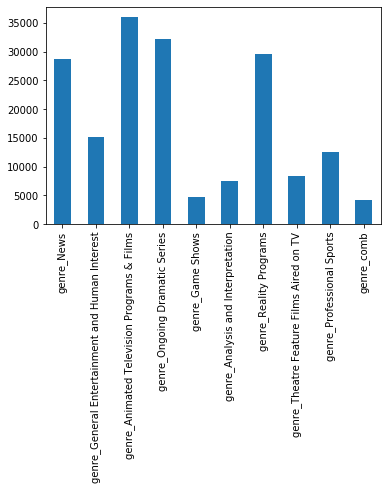

In [43]:
X_train_tmp[col_genres_tmp].sum().plot(kind='bar')

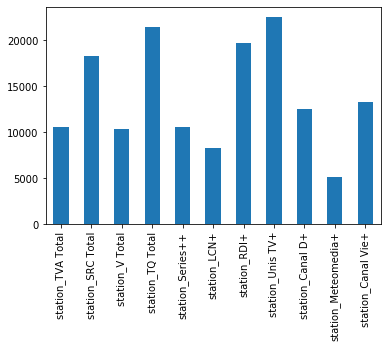

In [22]:
X_train[col_stations].sum().plot(kind='bar')

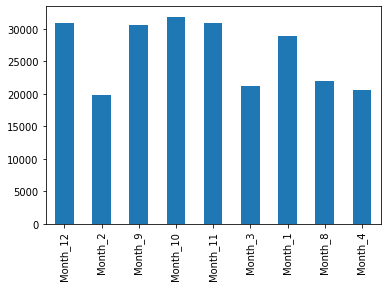

In [39]:
X_train[col_months].sum().plot(kind='bar')

### -. PCA --- not completed

In [17]:
pca = PCA(n_components=None)
pca.fit(X=X_train.values)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [40]:
pca_var = pca.explained_variance_ratio_
pca_var[:10].sum()

0.6300884236077366

In [41]:
pca = PCA(n_components=10)

In [42]:
X_train_dr = pca.fit_transform(X=X_train.values)
X_test_dr = pca.transform(X=X_test.values)

In [43]:
X_train.shape, X_train_dr.shape

((493324, 91), (493324, 10))

In [44]:
X_test.shape, X_test_dr.shape

((123332, 91), (123332, 10))

#### - Evaluate PCA reduced data

In [47]:
# instantiate a RandomForestRegressor object using the researched hyper-parameters
rf = RandomForestRegressor(n_estimators=150, max_depth=None, min_samples_leaf=2, max_features=0.5, n_jobs=-1, random_state=rs, oob_score=True)

In [48]:
%%time
# training the RandomForest model with non-transformed y values
print(time.ctime())
rf.fit(X_train_dr, y_train.iloc[:, 1].values)

Sat Feb 22 00:55:42 2020
Wall time: 5min 15s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=7, verbose=0, warm_start=False)

In [49]:
# top 10 most important features for the RandomForest model
sorted(zip(rf.feature_importances_, X_train.columns), reverse=True)[:10]

[(0.40535161040497497, 'temperature'),
 (0.21982713236477797, 'ch_type'),
 (0.08271943796669885, 'overlaped_with_game'),
 (0.07421614770528699, 'is_movie'),
 (0.046469575661957654, 'Is_month_end'),
 (0.04515357395521569, 'episodes_in_season'),
 (0.035972023946313374, 'first_or_rerun'),
 (0.031193040661588053, 'Is_quarter_end'),
 (0.030380885153154295, 'Is_month_start'),
 (0.028716572180032263, 'length')]

In [50]:
# make predictions
rf_preds = rf.predict(X_test_dr)

In [54]:
# evaluating the RandomForest model
evaluate(y_test.iloc[:, 1].values, rf_preds)

{'MAE': 1.4514769000873666,
 'MSE': 6.435371146871701,
 'R^2': 0.7344745436564479}

## -. SparsePCA --- not completed

In [56]:
spca = SparsePCA(n_components=10, random_state=rs)

In [57]:
X_train_sdr = spca.fit_transform(X=X_train.values)
X_test_sdr = spca.transform(X=X_test.values)

In [58]:
X_train.shape, X_train_sdr.shape

((493324, 91), (493324, 10))

In [59]:
# instantiate a RandomForestRegressor object using the researched hyper-parameters
rf = RandomForestRegressor(n_estimators=100, max_depth=30, n_jobs=-1, random_state=rs)

In [60]:
%%time
# training the RandomForest model with non-transformed y values
print(time.ctime())
rf.fit(X_train_sdr, y_train.iloc[:, 1].values)

Sat Feb 22 01:46:18 2020
Wall time: 5min 27s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=7, verbose=0, warm_start=False)

In [61]:
# top 10 most important features for the RandomForest model
sorted(zip(rf.feature_importances_, X_train.columns), reverse=True)[:10]

[(0.4553702704232678, 'temperature'),
 (0.19889021036921006, 'ch_type'),
 (0.102520397123655, 'overlaped_with_game'),
 (0.06183333057032992, 'is_movie'),
 (0.052246417659769624, 'Is_month_end'),
 (0.034886186825477845, 'first_or_rerun'),
 (0.028156347711736685, 'episodes_in_season'),
 (0.02420950418344279, 'length'),
 (0.02207324690571624, 'Is_quarter_end'),
 (0.019814088227394017, 'Is_month_start')]

In [62]:
# make predictions
rf_preds = rf.predict(X_test_sdr)

In [63]:
# evaluating the RandomForest model
evaluate(y_test.iloc[:, 1].values, rf_preds)

{'MAE': 1.2693409352681773,
 'MSE': 4.949469472597897,
 'R^2': 0.7957833184168581}